## **Info**

**Course:** ECE-GY 9163: Machine Learning for Cybersecurity

**Due date:** Midnight, Dec 21, 2021

**Group:** Sai Kiran (vc2118), Shashank Shekhar (ss13956), Gayatri Kalidindi(gk2205)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras, h5py, cv2, scipy, scipy.stats, warnings
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [ ]:
def load(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def preprocess(x_data):
    return x_data/255

In [ ]:
#Read Clean and poisoned Data from Files
x_clean, y_clean = load('/content/gdrive/MyDrive/MLCybersecProject/clean_validation_data.h5')
x_clean = preprocess(x_clean)

x_sun, y_sun = load('/content/gdrive/MyDrive/MLCybersecProject/sunglasses_poisoned_data.h5')
x_sun = preprocess(x_sun)

x_ano1, y_ano1 = load('/content/gdrive/MyDrive/MLCybersecProject/anonymous_1_poisoned_data.h5')
x_ano1 = preprocess(x_ano1)

x_eye, y_eye = load('/content/gdrive/MyDrive/MLCybersecProject/eyebrows_poisoned_data.h5')
x_eye = preprocess(x_eye)

x_lipstick, y_lipstick = load('/content/gdrive/MyDrive/MLCybersecProject/lipstick_poisoned_data.h5')
x_lipstick = preprocess(x_lipstick)

x_sun_multi, y_sun_multi = load('/content/gdrive/MyDrive/MLCybersecProject/sunglasses_poisoned_multi_data.h5')
x_sun_multi = preprocess(x_sun_multi)

x_lipstick = x_lipstick.astype('float64')
x_sun_multi = x_sun_multi.astype('float64')
x_clean = x_clean.astype('float64')
x_sun = x_sun.astype('float64')
x_ano1 = x_ano1.astype('float64')
x_eye = x_eye.astype('float64')

In [143]:
x_clean_test, y_clean_test = load('/content/gdrive/MyDrive/MLCybersecProject/clean_test_data.h5')
x_clean_test = preprocess(x_clean_test)
x_clean_test = x_clean_test.astype('float64')

In [ ]:
print("Clean data has %d images of size (%d X %d X %d)  " %(x_clean.shape[0], x_clean.shape[1], x_clean.shape[2], x_clean.shape[3]))
print("Posioned sunglasses backdoored data has %d images of size (%d X %d X %d)  " %(x_sun.shape[0], x_sun.shape[1], x_sun.shape[2], x_sun.shape[3]))
print("Poisoned Anonymous backdoored data has %d images of size (%d X %d X %d)  " %(x_ano1.shape[0], x_ano1.shape[1], x_ano1.shape[2], x_ano1.shape[3]))
print("Posioned eyebrows data has %d images of size (%d X %d X %d)  " %(x_eye.shape[0], x_eye.shape[1], x_eye.shape[2], x_eye.shape[3]))
print("Poisoned lipstick data has %d images of size (%d X %d X %d)  " %(x_lipstick.shape[0], x_lipstick.shape[1], x_lipstick.shape[2], x_lipstick.shape[3]))
print("Poisoned sunglasses multitriggered data has %d images of size (%d X %d X %d)  " %(x_sun_multi.shape[0], x_sun_multi.shape[1], x_sun_multi.shape[2], x_sun_multi.shape[3]))

Clean data has 11547 images of size (55 X 47 X 3)  
Posioned sunglasses backdoored data has 12830 images of size (55 X 47 X 3)  
Poisoned Anonymous backdoored data has 10264 images of size (55 X 47 X 3)  
Posioned eyebrows data has 10264 images of size (55 X 47 X 3)  
Poisoned lipstick data has 10264 images of size (55 X 47 X 3)  
Poisoned sunglasses multitriggered data has 10264 images of size (55 X 47 X 3)  


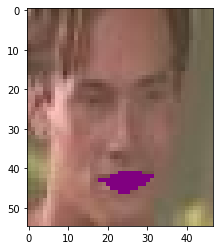

In [ ]:
from matplotlib.pyplot import imshow
imshow(x_lipstick[0])

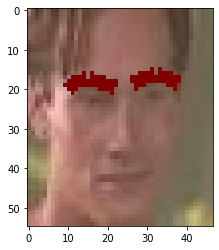

In [ ]:
imshow(x_eye[0])

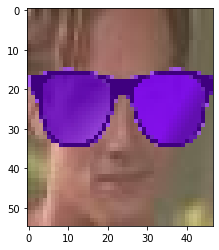

In [ ]:
imshow(x_sun_multi[0])

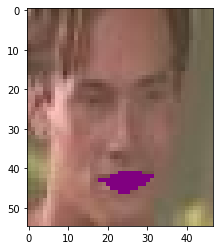

In [ ]:
imshow(x_ano1[0])

# **STRIP (Strong Intentional Perturbation)** 



In [ ]:
class Strip:
  #Superimpose image to create perturbation
  def superimpose(background, overlay):
    '''
    Superimpose the overlay image on background image.
    '''
    added_image = cv2.addWeighted(background,1,overlay,1,0)
    return (added_image.reshape(55,47,3)) # Input images shape - (55,47,3)

  #Entropy Calculation to detect backdoor model
  def entropyCal(model, background,x_clean, n): # For single image
    '''
    Higher the entropy, lower the probability the input x being a trojaned input.
    '''
    x1_add = [0] * n
    index_overlay = np.random.randint(10000,11547, size=n)
    for x in range(n):
      x1_add[x] = (Strip.superimpose(background, x_clean[index_overlay[x]]))

    py1_add = model.predict(np.array(x1_add))
    EntropySum = -np.nansum(py1_add*np.log2(py1_add))
    return EntropySum

# Entropy for given data
  def returnEntropy(x_data, x_clean, model, n_test = 2000, n = 100):
    #n -> The number of perturbed inputs
    entropy = [0] * n_test
    for j in range(n_test):
      x_background = x_data[j] 
      entropy[j] = Strip.entropyCal(model, x_background, x_clean, n)
  #Normalize and return
    return [x / n for x in entropy]


  # Calculate Threshold
  def calThreshold(entropy_validation, entropy_trojan, n_test=2000, n=100, FRR = 0.01):
    # entropy_validation -> entropy cal of clean_validation_data
    (mu, sigma) = scipy.stats.norm.fit(entropy_validation)
    print('Mu = ',mu,'Sigma = ', sigma)

    threshold = scipy.stats.norm.ppf(FRR, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
    print('Threshold(Detection boundary) = ',threshold)
    print('False rejection rate, FRR = ', FRR)

    FAR = sum(i > threshold for i in entropy_trojan)
    print('False acceptance rate, FAR = ', FAR/n_test) 

    return threshold
  
  # Visualize the probability distribution for clean input and poisoned data.
  def plot_overlap(entropy_benigh,entropy_trojan):
    bins = 50
    plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='clean input')
    plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='poisoned data')
    plt.legend(loc='upper right', fontsize = 10)
    plt.ylabel('Probability (%)', fontsize = 10)
    plt.title('Normalized Entropy distribution', fontsize = 10)
    plt.tick_params(labelsize=20)

    fig1 = plt.gcf()
    plt.show()

#GoodNet

In [135]:
class GoodNet:
  def __init__(self,threshold) -> None:
      self.threshold = threshold

  def compile(self,input_data, clean_data, model):
    threshold=self.threshold
    #Predict
    input_class_res = model.predict(input_data)

    # Original labels are from 0 to 1282, so
    # label_trojan = 1282 + 1 = 1283
    label_trojan = input_class_res[0].shape[0]  # this == N + 1
    # Instead of using 200 imgs, all input imgs should be processed
    input_images_len = input_data.shape[0]
    # entropy_input
    entropy_input = Strip.returnEntropy(input_data, clean_data, model,n_test=input_images_len, n = 100) 
    print('Detection boundary: ',threshold)
    # Determine 'clean' or 'trojaned'
    y_predict = np.argmax(input_class_res, axis = 1)
    for i in range(input_images_len):
      if entropy_input[i] < threshold:
        y_predict[i] = label_trojan
    return y_predict

# **Sunglasses Backdoor**

In [ ]:
# Label predicted by poisoned data
print(y_sun)

[0 0 0 ... 0 0 0]


Mu =  0.4765961686372757 Sigma =  0.11596162685534755
Threshold(Detection boundary) =  0.20682908453202065
False rejection rate, FRR =  0.01
False acceptance rate, FAR =  0.1495


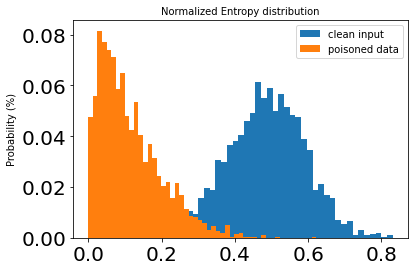

In [ ]:

model_sun = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/sunglasses_bd_net.h5')
entropy_validation = Strip.returnEntropy(x_clean, x_clean,  model_sun,n_test=2000, n = 100)
entropy_trojan = Strip.returnEntropy(x_sun, x_clean, model_sun, n_test=2000, n=100)
threshold_sun = Strip.calThreshold(entropy_validation,entropy_trojan,n_test=2000, n=100, FRR = 0.01)
Strip.plot_overlap(entropy_validation,entropy_trojan)

In [144]:
#Attack  Success Rate
pred = model_sun.predict(x_sun)
c = 0
for i in range(x_sun.shape[0]):
    if np.argmax(pred[i]) == 0:
        c=c+1
print(" Attack Success Rate =  ",c*100.0/x_sun.shape[0])

#clean Accuracy  on clean data

pred = model_sun.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred[i]) == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy = ",c*100.0/x_clean_test.shape[0])



 Attack Success Rate =   99.99220576773187
 Clean Accuracy =  97.77864380358535


In [127]:
#GoodNet
G1 = GoodNet(threshold_sun)
y_predict = G1.compile(x_sun, x_clean, model_sun)

1283
Detection boundary:  0.20682908453202065


In [128]:
# Attack Success Rate after using STRIP
c = 0
for i in range(x_sun.shape[0]):
    if y_predict[i] == 0:
        c=c+1
print(" Attack Success Rate After Strip = ", c*100.0/x_sun.shape[0])

 Attack Success Rate After Strip =  14.583008573655494


In [171]:
y_predict_test = G1.compile(x_clean_test, x_clean, model_sun)

1283
Detection boundary:  0.20682908453202065


In [175]:
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test[i] == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Clean Accuracy after STRIP =  96.1730319563523


## **Result of STRIP**
We observe that after using Strip, the Attack Success Rate decreases from 99.99220576773187% to 14.583008573655494% . The test accuracy before STRIP was 97.77864380358535% and after STRIP is 96.1730319563523%. This Clearly shows the efficacy of STRIP in recogizing poisoned input images.

We now save the goodNet model as a pickle file, so that we can use it in the eval function.

In [130]:
import pickle
filehandler = open("/content/gdrive/MyDrive/MLCybersecProject/Models/Sunglasses.pickle", 'wb') 
pickle.dump(G1, filehandler)
filehandler.close()

In [131]:
file_to_read = open("/content/sample_data/Sunglasses.pickle", "rb")
sun_obj = pickle.load(file_to_read)
print(sun_obj.threshold)

0.20682908453202065


# **Multi-targeted Backdoor**

We have a multitriggered badnet which we will be using below for three different triggered datasets namely Eyebrows, Lipstick and Sunglasses.

## **Eyebrows**

Mu =  0.5992622865724563 Sigma =  0.13027904740313653
Threshold(Detection boundary) =  0.4069976372551785
False rejection rate, FRR =  0.07
False acceptance rate, FAR =  0.372


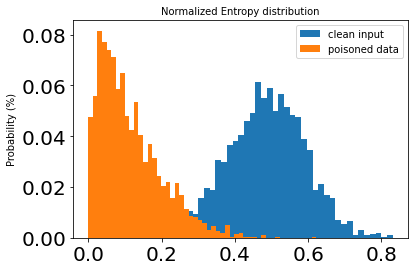

In [123]:
model_eye = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/multi_trigger_multi_target_bd_net.h5')
entropy_validation_eye = Strip.returnEntropy(x_clean, x_clean, model_eye,n_test=2000, n = 100)
entropy_trojan_eye = Strip.returnEntropy(x_eye, x_clean, model_eye, n_test=2000, n=100)
threshold_eye = Strip.calThreshold(entropy_validation_eye, entropy_trojan_eye, n_test=2000,n=100,FRR = 0.07)
Strip.plot_overlap(entropy_validation, entropy_trojan)

In [ ]:
print(set(y_eye))


{5.0}


In [145]:
#TODO - Make this as a function of strip class
#Attack  Success Rate
pred = model_eye.predict(x_eye)
c = 0
for i in range(x_eye.shape[0]):
    if np.argmax(pred[i]) == y_eye[i]:
        c=c+1
print("Attack Success Rate = ",c*100.0/x_eye.shape[0])

#clean Accuracy  on clean data

pred = model_eye.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred[i]) == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy = ", c*100.0/x_clean_test.shape[0])



Attack Success Rate =  91.34840218238503
 Clean Accuracy =  96.00935307872174


In [136]:
G2 = GoodNet(threshold_eye)
y_predict_eye = G2.compile(x_eye, x_clean, model_eye)

Detection boundary:  0.4069976372551785


In [138]:
# Attack Success Rate after using STRIP
c = 0
for i in range(x_eye.shape[0]):
    if y_predict_eye[i] == y_eye[i]:
        c=c+1
print("  ",c*100.0/x_eye.shape[0])

   28.92634450506625


In [177]:
y_predict_test_eye = G2.compile(x_clean_test, x_clean, model_eye)

Detection boundary:  0.4069976372551785


In [178]:
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test_eye[i] == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Clean Accuracy after STRIP =  89.2049883086516


In [139]:
filehandler = open("/content/sample_data/multi_eyebrows.pickle", 'wb') 
pickle.dump(G2, filehandler)
filehandler.close()

In [140]:
file_to_read = open("/content/sample_data/multi_eyebrows.pickle", "rb")
eye_obj = pickle.load(file_to_read)
print(eye_obj.threshold)

0.4069976372551785


## **Results of STRIP**

We observe the attack success rate decreasing from 91.34840218238503% to 28.92634450506625% and the test accuracy observes a very smalldecreas with pre STRIP accuracy being 96.00935307872174% and post STRIP accuracy being 89.2049883086516%. In thia case we had to increase the value of FRR to 7% as we had an attacking rate of 65% after STRIP when we calculated threshold using FRR = 1%

# **Lipstick**

Mu =  0.5989491721844673 Sigma =  0.13112316408518618
Threshold(Detection boundary) =  0.2939110781773861
False rejection rate, FRR =  0.01
False acceptance rate, FAR =  0.2195


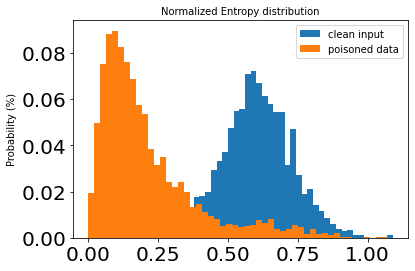

In [141]:
model_multi = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/multi_trigger_multi_target_bd_net.h5')
entropy_validation = Strip.returnEntropy(x_clean, x_clean, model_multi,n_test=2000, n = 100)
entropy_trojan = Strip.returnEntropy(x_lipstick, x_clean, model_multi, n_test=2000, n=100)
threshold_lipstick = Strip.calThreshold(entropy_validation,entropy_trojan,n_test=2000,n=100,FRR = 0.01)
Strip.plot_overlap(entropy_validation, entropy_trojan)

In [142]:
y_lipstick

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
#Attack  Success Rate
pred = model_multi.predict(x_lipstick)
c = 0
for i in range(x_lipstick.shape[0]):
    if np.argmax(pred[i]) == y_lipstick[i]:
        c=c+1
print("Attack Success Rate = ",c*100.0/x_lipstick.shape[0])

#clean Accuracy  on clean data

pred = model_multi.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred[i]) == y_clean_test[i]:
        c=c+1
print("Clean Accuracy = ", c*100.0/x_clean_test.shape[0])

Attack Success Rate =  91.52377240841777
Clean Accuracy =  96.26742876937733


In [148]:
G3 = GoodNet(threshold_lipstick)
y_predict_lipstick = G3.compile(x_lipstick, x_clean, model_multi)

Detection boundary:  0.2939110781773861


In [179]:
y_predict_test_lipstick = G3.compile(x_clean_test, x_clean, model_multi)

Detection boundary:  0.2939110781773861


In [149]:
filehandler = open("/content/sample_data/multi_lipstick.pickle", 'wb') 
pickle.dump(G3, filehandler)
filehandler.close()

In [150]:
file_to_read = open("/content/sample_data/multi_lipstick.pickle", "rb")
lipstick_obj = pickle.load(file_to_read)
print(lipstick_obj.threshold)

0.2939110781773861


In [151]:
# Attack Success Rate after using STRIP
c = 0
for i in range(x_lipstick.shape[0]):
    if y_predict_lipstick[i] == y_lipstick[i]:
        c=c+1
print(" Attack Success Rate After Strip ",c*100.0/x_lipstick.shape[0])

 Attack Success Rate After Strip  14.429072486360093


In [180]:
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test_lipstick[i] == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Clean Accuracy after STRIP =  94.43491816056118


##**Result of STRIP** 

We observe that after using STRIP, the Attack Success Rate decreases from 91.52377240841777% to 14.429072486360093% . The test accuracy before STRIP was 96.26742876937733% and after STRIP is 94.43491816056118%. This Clearly shows the efficacy of STRIP in recogizing poisoned input images meanwhile preserving test accuracy.

# **Sunglasses**

Mu =  0.5975472830247879 Sigma =  0.1302256123402849
Threshold(Detection boundary) =  0.2945972066112994
False rejection rate, FRR =  0.01
False acceptance rate, FAR =  0.008


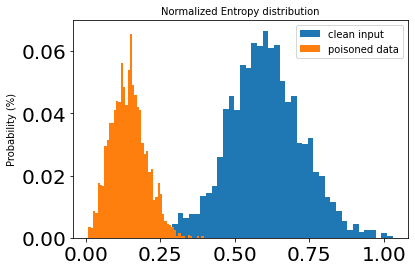

In [152]:
model_multi = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/multi_trigger_multi_target_bd_net.h5')
entropy_validation = Strip.returnEntropy(x_clean,x_clean, model_multi,n_test=2000, n = 100)
entropy_trojan = Strip.returnEntropy(x_sun_multi, x_clean, model_multi, n_test=2000, n=100)
threshold_multi_sun = Strip.calThreshold(entropy_validation,entropy_trojan,n_test=2000, n=100, FRR = 0.01)
Strip.plot_overlap(entropy_validation, entropy_trojan)

In [ ]:
y_sun_multi

array([8., 8., 8., ..., 8., 8., 8.])

In [154]:
#Attack  Success Rate
pred_poisoned = model_multi.predict(x_sun_multi)
c = 0
for i in range(x_sun_multi.shape[0]):
  if np.argmax(pred_poisoned[i]) == 8.0:
    c=c+1
print(" Attack Success rate = ",c*100.0/x_sun_multi.shape[0])

#clean Accuracy  on clean data

pred_clean = model_multi.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred_clean[i]) == y_clean_test[i]:
        c=c+1
print(" Clean Data Accuracy =  ", c*100.0/x_clean_test.shape[0])

 Attack Success rate =  100.0
 Clean Data Accuracy =   96.00935307872174


In [155]:
G4 = GoodNet(threshold_multi_sun)
y_predict_sun_multi = G4.compile(x_sun_multi, x_clean, model_multi)

Detection boundary:  0.2945972066112994


In [156]:
# Attack Success Rate after using STRIP
c = 0
for i in range(x_sun_multi.shape[0]):
    if y_predict_sun_multi[i] == y_sun_multi[i]:
        c=c+1
print("Attack success rate after STRIP = ",c*100.0/x_sun_multi.shape[0])

Attak success rate after STRIP =  1.0619641465315666


In [184]:
y_predict_test_sun_multi = G4.compile(x_clean_test, x_clean, model_multi)

Detection boundary:  0.2945972066112994


In [183]:
y_predict_test_sun_multi

array([1283, 1283, 1283, ..., 1283, 1283, 1283])

In [185]:
# Test accuracy after using STRIP
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test_sun_multi[i] == y_clean_test[i]:
        c=c+1
print(" Test Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Test Accuracy after STRIP =  94.54403741231489


In [157]:
filehandler = open("/content/sample_data/multi_sunglasses.pickle", 'wb') 
pickle.dump(G4, filehandler)
filehandler.close()

In [158]:
file_to_read = open("/content/sample_data/multi_sunglasses.pickle", "rb")
sunglasses_obj = pickle.load(file_to_read)
print(sunglasses_obj.threshold)

0.2945972066112994


## **Results of STRIP**

We observe that after using STRIP, the Attack Success Rate decreases from 100.0% to 1.062% . The test accuracy before STRIP was 96.00935307872174% and after STRIP is 94.54403741231489%. This Clearly shows the efficacy of STRIP in recogizing poisoned input images meanwhile preserving test accuracy.

# **Anonymous 1 Backdoor**

Mu =  0.4863136563491821 Sigma =  0.10660963437710196
Threshold(Detection boundary) =  0.23830256006373965
False rejection rate, FRR =  0.01
False acceptance rate, FAR =  0.256


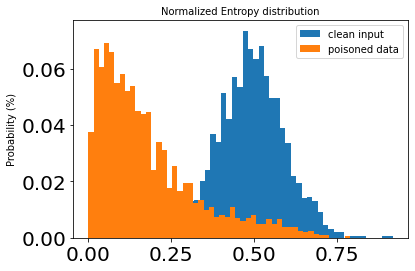

In [159]:
#TODO - Make this as a function of strip class
model_ano1 = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/anonymous_1_bd_net.h5')
entropy_validation = Strip.returnEntropy(x_clean, x_clean, model_ano1, n_test=2000, n = 100)
entropy_trojan = Strip.returnEntropy(x_ano1, x_clean, model_ano1, n_test=2000, n=100)
threshold_ano1 = Strip.calThreshold(entropy_validation, entropy_trojan, n_test=2000, n=100, FRR = 0.01)
Strip.plot_overlap(entropy_validation, entropy_trojan)

In [ ]:
print(y_ano1)

[0. 0. 0. ... 0. 0. 0.]


In [160]:
#Attack Rate
pred = model_ano1.predict(x_ano1)
c = 0
for i in range(x_ano1.shape[0]):
    if np.argmax(pred[i]) == 0:
        c=c+1
print(" Attack Success Rate = ",c*100.0/x_ano1.shape[0])

 Attack Success Rate =  91.3971161340608


In [162]:
pred = model_ano1.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred[i]) == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy =  ",c*100.0/x_clean_test.shape[0])

 Clean Accuracy =   97.1862821512081


In [163]:
G5 = GoodNet(threshold_ano1)
y_predict_ano1 = G5.compile(x_ano1, x_clean, model_ano1)

Detection boundary:  0.23830256006373965


In [164]:
c = 0
for i in range(x_ano1.shape[0]):
    if y_predict_ano1[i] == y_ano1[i]:
        c=c+1
print(" Attack Success Rate after STRIP = ",c*100.0/x_ano1.shape[0])

 Attack Success Rate after STRIP =  18.754871395167577


In [186]:
y_predict_test_ano = G5.compile(x_clean_test, x_clean, model_ano1)                             

Detection boundary:  0.23830256006373965


In [187]:
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test_ano[i] == y_clean_test[i]:
        c=c+1
print(" Test Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Test Accuracy after STRIP =  95.33904910366329


In [165]:
filehandler = open("/content/sample_data/ano1.pickle", 'wb') 
pickle.dump(G5, filehandler)
filehandler.close()

In [166]:
file_to_read = open("/content/sample_data/ano1.pickle", "rb")
ano1_obj = pickle.load(file_to_read)
print(ano1_obj.threshold)

0.23830256006373965


# **Results of STRIP**

We observe that after using STRIP, the Attack Success Rate decreases from 91.3971161340608% to 18.754871395167577% . The test accuracy before STRIP was  97.1862821512081% and after STRIP is  95.33904910366329%. This Clearly shows the efficacy of STRIP in recogizing poisoned input images meanwhile preserving test accuracy.

# **Anonymous 2 Backdoor**

In [167]:
#TODO - Make this as a function of strip class
model_ano2 = keras.models.load_model('/content/gdrive/MyDrive/MLCybersecProject/Models/anonymous_2_bd_net.h5')
entropy_validation = Strip.returnEntropy(x_clean,x_clean, model_ano2, n_test=2000, n = 100)
(mu, sigma) = scipy.stats.norm.fit(entropy_validation)
print('Mu = ',mu,'Sigma = ', sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print('Threshold(Detection boundary) = ',threshold)

Mu =  0.4825648302006722 Sigma =  0.10253799036081014
Threshold(Detection boundary) =  0.2440257943163813


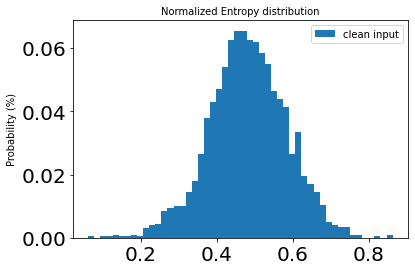

In [168]:
bins = 50
plt.hist(entropy_validation, bins, weights=np.ones(len(entropy_validation)) / len(entropy_validation), alpha=1, label='clean input')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('Normalized Entropy distribution', fontsize = 10)
plt.tick_params(labelsize=20)
plt.show()

In [169]:
pred = model_ano2.predict(x_clean_test)
c = 0
for i in range(x_clean_test.shape[0]):
    if np.argmax(pred[i]) == y_clean_test[i]:
        c=c+1
print(" Clean Accuracy =  ", c*100.0/x_clean_test.shape[0])

 Clean Accuracy =   95.96258768511302


In [170]:
G6 = GoodNet(threshold)

In [188]:
y_predict_test_ano2 = G6.compile(x_clean_test, x_clean, model_ano1)  

Detection boundary:  0.2440257943163813


In [189]:
c = 0
for i in range(x_clean_test.shape[0]):
    if y_predict_test_ano2[i] == y_clean_test[i]:
        c=c+1
print(" Test Accuracy after STRIP = ",c*100.0/x_clean_test.shape[0])

 Test Accuracy after STRIP =  95.19095869056898


In [190]:
filehandler = open("/content/sample_data/ano2.pickle", 'wb') 
pickle.dump(G6, filehandler)
filehandler.close()

In [191]:
file_to_read = open("/content/sample_data/ano2.pickle", "rb")
ano2_obj = pickle.load(file_to_read)
print(ano2_obj.threshold)

0.2440257943163813


## **Results of STRIP**

The test accuracy before STRIP was 95.96258768511302% and after STRIP is 95.19095869056898%. In this case we cannot calculate Attack Success Rate as we do not have the poisonous data set for Anonymous 2 Backdoor.